In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_val_path = '../../data/images/Training/'
test_path = '../../data/images/Test/'

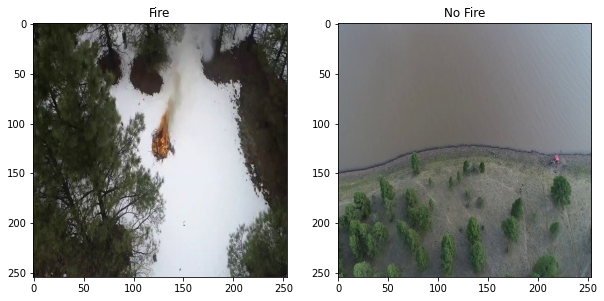

In [9]:
# looking at one fire and no fire image from the training set

fire = plt.imread(train_val_path + 'Fire/resized_frame0.jpg')
no_fire = plt.imread(train_val_path + 'No_Fire/lake_resized_lake_frame0.jpg')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(fire)
ax[0].set_title('Fire')
ax[1].imshow(no_fire)
ax[1].set_title('No Fire')
plt.show()

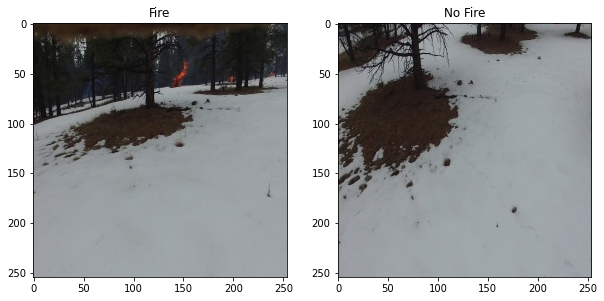

In [10]:
# looking at one fire and no fire image from the testing set

fire = plt.imread(test_path + 'Fire/resized_test_fire_frame0.jpg')
no_fire = plt.imread(test_path + 'No_Fire/resized_test_nofire_frame0.jpg')

fig, ax = plt.subplots(1 ,2, figsize = (10, 5))
ax[0].imshow(fire)
ax[0].set_title('Fire')
ax[1].imshow(no_fire)
ax[1].set_title('No Fire')
plt.show()

In [11]:
# preprocessing the images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range = 40,
                                        width_shift_range = 0.2,
                                        height_shift_range = 0.2,
                                        shear_range = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_val_path,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(train_val_path,
                                                        target_size = (150, 150),
                                                        batch_size = 32,
                                                        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_path,
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = 'binary')

Found 39375 images belonging to 2 classes.
Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [12]:
# building the model taking VGG16 as the base model

from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                    include_top = False,
                    input_shape = (150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [13]:
# freezing the base model

conv_base.trainable = False

# building the model

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'sigmoid'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [16]:
# compiling the model

from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.legacy.RMSprop(learning_rate = 2e-5),
                metrics = ['acc'])

In [19]:
# fitting the model

# early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss',
                                patience = 3,
                                restore_best_weights = True)

history = model.fit(train_generator,
                                steps_per_epoch = 100,
                                epochs = 30,
                                validation_data = validation_generator,
                                validation_steps = 50,
                                callbacks = [early_stopping])

# plotting the training and validation accuracy and loss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

Epoch 1/30


2023-07-11 00:51:58.031163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.3470 - acc: 0.9453

2023-07-11 00:54:03.777484: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 184s 2s/step - loss: 0.3470 - acc: 0.9453 - val_loss: 0.2752 - val_acc: 0.9538
Epoch 2/30
100/100 [==============================] - 181s 2s/step - loss: 0.2346 - acc: 0.9472 - val_loss: 0.2160 - val_acc: 0.9431
Epoch 3/30
100/100 [==============================] - 182s 2s/step - loss: 0.2090 - acc: 0.9375 - val_loss: 0.1710 - val_acc: 0.9538
Epoch 4/30
100/100 [==============================] - 177s 2s/step - loss: 0.1874 - acc: 0.9391 - val_loss: 0.1709 - val_acc: 0.9506
Epoch 5/30
100/100 [==============================] - 181s 2s/step - loss: 0.1789 - acc: 0.9450 - val_loss: 0.1462 - val_acc: 0.9544
Epoch 6/30
100/100 [==============================] - 205s 2s/step - loss: 0.1629 - acc: 0.9525 - val_loss: 0.1706 - val_acc: 0.9312
Epoch 7/30
100/100 [==============================] - 208s 2s/step - loss: 0.1495 - acc: 0.9544 - val_loss: 0.1416 - val_acc: 0.9550
Epoch 8/30
100/100 [==============================] - 205s 2s/step - loss: 0.140

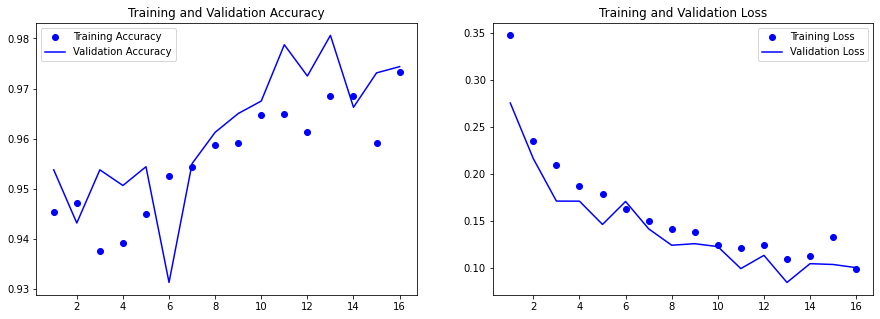

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(epochs, acc, 'bo', label = 'Training Accuracy')

ax[0].plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label = 'Training Loss')

ax[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

# evaluating the model on the test set

In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps = 50)

print('Test Accuracy:', test_acc)

2023-07-11 04:31:56.615212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 59s 1s/step - loss: 0.7147 - acc: 0.6881
Test Accuracy: 0.6881250143051147


In [22]:
# saving the model

model.save('../../models/created_models/first_classifier.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
